In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_path = '/content/drive/MyDrive/liar/train.tsv'
valid_path = '/content/drive/MyDrive/liar/valid.tsv'
test_path = '/content/drive/MyDrive/liar/test.tsv'

train_df = pd.read_csv(train_path,delimiter='\t',header=None, names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])
valid_df = pd.read_csv(valid_path,delimiter='\t',header=None, names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])
test_df = pd.read_csv(test_path,delimiter='\t',header=None, names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])
train_df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,label,statement,subject,speaker,job,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


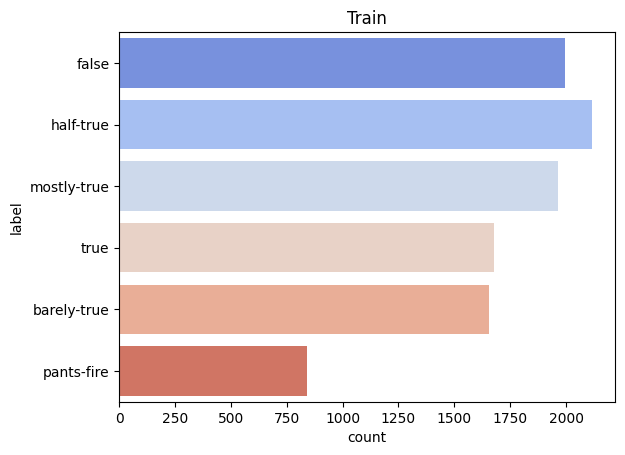

In [2]:
sns.countplot(y="label", palette="coolwarm", data=train_df).set_title('Train')
plt.show()

In [3]:
print(train_df.shape)
train_df.isna().sum()

(10240, 14)


id                    0
label                 0
statement             0
subject               2
speaker               2
job                2897
state              2208
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
venue               102
dtype: int64

In [4]:
print(valid_df.shape)
valid_df.isna().sum()

(1284, 14)


id                   0
label                0
statement            0
subject              0
speaker              0
job                345
state              279
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
venue               12
dtype: int64

In [5]:
print(test_df.shape)
test_df.isna().sum()

(1267, 14)


id                   0
label                0
statement            0
subject              0
speaker              0
job                325
state              262
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
venue               17
dtype: int64

In [6]:
from sklearn.utils import shuffle

train_df = train_df[['statement','label']]
valid_df = valid_df[['statement','label']]
test_df = test_df[['statement','label']]
# Shuffle
train_df = shuffle(train_df).reset_index(drop=True)
valid_df = shuffle(valid_df).reset_index(drop=True)
test_df = shuffle(test_df).reset_index(drop=True)

def convert_to_int(value):
    if value in ['barely-true', 'half-true', 'mostly-true', 'true']:
        return 1
    elif value in ['false', 'pants-fire']:
        return 0
    else:
        return value



train_df['label']=train_df['label'].apply(convert_to_int)
valid_df['label']=valid_df['label'].apply(convert_to_int)
test_df['label']=test_df['label'].apply(convert_to_int)

train_df.drop_duplicates(subset=['statement'],keep='first',inplace=True)
valid_df.drop_duplicates(subset=['statement'],keep='first',inplace=True)
test_df.drop_duplicates(subset=['statement'],keep='first',inplace=True)

df = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['statement'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [9]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))

Number of titles: 12774
Max length of the titles: 334
Mean length of the titles: 10.694692343823391


In [10]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['statement'])
sequences = tokenizer.texts_to_sequences(df['statement'])
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


In [11]:
train_len = len(train_df)
val_len = len(valid_df)
test_len = len(test_df)

x_train = np.array(padded_df[:train_len])
y_train = np.array(train_df['label'])

x_val = np.array(padded_df[train_len:train_len + val_len])
y_val = np.array(valid_df['label'])

x_test = np.array(padded_df[-test_len:])
y_test = np.array(test_df['label'])



# **LSTM**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Epoch 1/3
160/160 [==============================] - 36s 126ms/step - loss: 0.5887 - accuracy: 0.7232 - val_loss: 0.5842 - val_accuracy: 0.7048
Epoch 2/3
160/160 [==============================] - 7s 47ms/step - loss: 0.5358 - accuracy: 0.7302 - val_loss: 0.5787 - val_accuracy: 0.7056
Epoch 3/3
160/160 [==============================] - 5s 30ms/step - loss: 0.4473 - accuracy: 0.7884 - val_loss: 0.6235 - val_accuracy: 0.6924


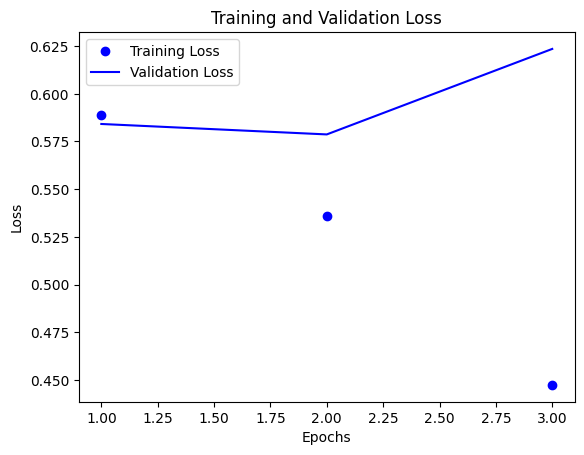

In [13]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

40/40 [==============================] - 1s 5ms/step
CNN-BiLSTM Model Accuracy :  0.7111286503551697
Precision :  0.7554744525547445
Recall :  0.8941684665226782
F1 :  0.8189910979228487
G-mean: 0.43751597559824246
Training time:  48.27281641960144
Inference time:  1.0330464839935303
              precision    recall  f1-score   support

           0       0.43      0.21      0.29       341
           1       0.76      0.89      0.82       926

    accuracy                           0.71      1267
   macro avg       0.59      0.55      0.55      1267
weighted avg       0.67      0.71      0.68      1267



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


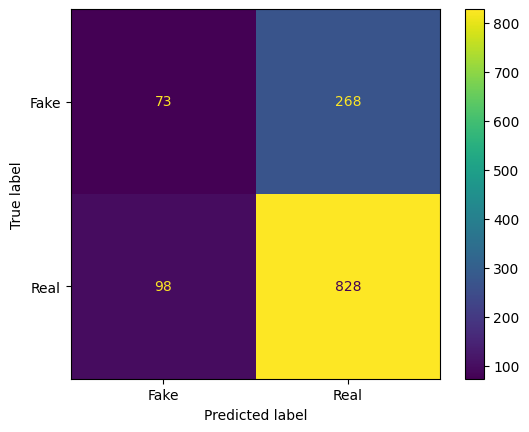

In [14]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()